# Introduction

In [64]:
%matplotlib inline

""" Run this code to import torch. 
If it prints out that cuda available is false, then you do not have a gpu.
To get a GPU, go to Runtime>change runtime type>Hardware accelerator and select
GPU from the drop down menu.
"""
import torch
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import cv2
print("Version:", torch.__version__)
print("Cuda available:", torch.cuda.is_available())

Version: 1.4.0
Cuda available: True


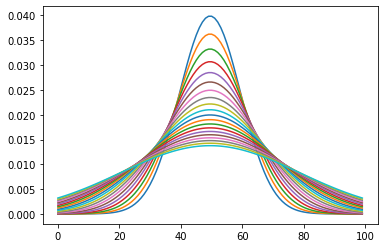

In [65]:
def gaussian1d(sigma, num_points):
    
  """
  GAUSSIAN1D - make discrete normalized centered 1D Gaussian

  Syntax: g = gaussian1d(sigma, num_points);

  Output is symmetric with unit sampling period.
  Zero is sampled only when num_points is odd.
  Examples:
    if num_points==3, sample points are [-1,0,1]
    if num_points==4, sample points are [-1.5, -0.5, 0.5, 1.5]
  Inputs:
    sigma: standard deviation
    num_points: output length.
  Outputs:
    g: a torch tensor representing the gaussian filter of dimension (num_points)
  """

  #implementing 1D Gaussian filter

  x_g = torch.zeros(num_points)
  g = torch.zeros(num_points)

  for i in range(num_points):
    x_ = -(num_points - 1)/2 + i 
    x_g[i] = x_ 
    g[i] = 1/(sigma * math.sqrt(2*math.pi)) * math.exp(-0.5 * (x_/sigma) **2)

  assert(isinstance(g, torch.Tensor))
  assert(len(g.shape) == 1 and g.shape[0] == num_points)
  return g


for sigma in range(10, 30):
  gaussian = gaussian1d(sigma, 100)
  plt.plot(gaussian)
pass

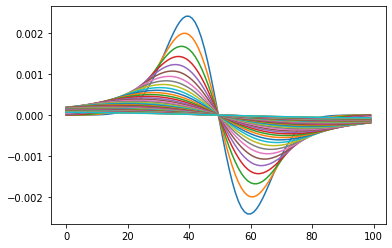

In [66]:
def gaussian_derivative1d(sigma, num_points):
    
  """ 
  Sample num_points from the derivative of a zero-mean gaussian function
  with standard deviation sigma.

  Zero is sampled only when num_points is odd.
  Examples:
    if num_points==3, sample points are [-1,0,1]
    if num_points==4, sample points are [-1.5, -0.5, 0.5, 1.5]
  """

  # Laplacian filter
    
  x_d = torch.zeros(num_points)
  derivative = torch.zeros(num_points)

  for i in range(num_points):
    x_ = -(num_points - 1)/2 + i 
    derivative[i] = -x_/(sigma**3 * math.sqrt(2*math.pi)) * math.exp(-0.5 * (x_/sigma) **2)

  assert(isinstance(derivative, torch.Tensor))
  assert(len(derivative.shape) == 1 and derivative.shape[0] == num_points)
  return derivative

for sigma in range(10, 60):
  derivative = gaussian_derivative1d(sigma, 100)
  plt.plot(derivative)
pass

# Edge Detection

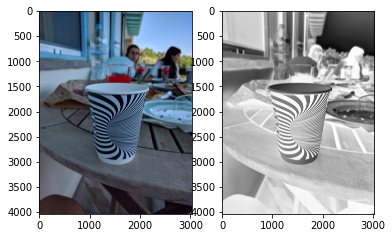

In [67]:
""" Loads and displays the sunflower image.  You must upload the image by 
clicking on the folder icon to the left, then clicking upload.  You will have to
re-upload the image every time your colab session restarts.
""" 
cup_im = cv2.imread('cup.jpg')[:, :, ::-1]
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(cup_im)
gray_im = cv2.cvtColor(cup_im, cv2.COLOR_BGR2GRAY)

ax2.imshow(gray_im, cmap='Greys')
gray_im = torch.tensor(gray_im).to(torch.float32).cuda()
pass

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


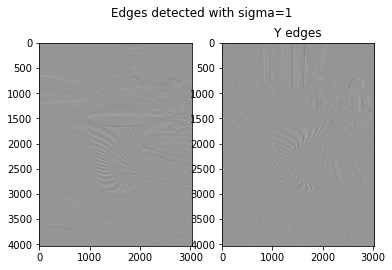

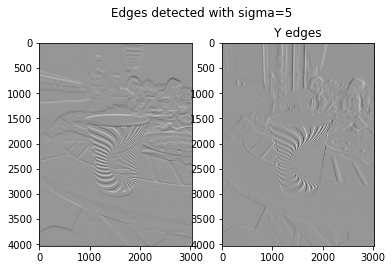

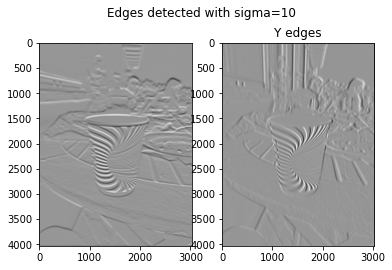

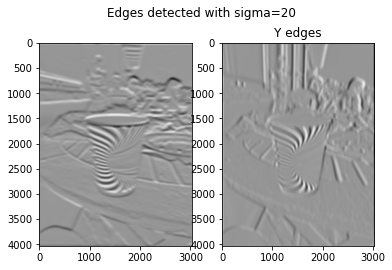

In [68]:
for sigma_i in [1, 5, 10, 20]:
    
  num_points = 2 * int(2 * sigma_i) + 1

  y_d = gaussian_derivative1d(sigma_i, num_points)
  x_d = y_d.view(num_points, 1)
  kernel_x = x_d.repeat(1, num_points)
  kernel_y = y_d.repeat(num_points,1)

  kernel_x = torch.tensor(kernel_x).to(torch.float32).cuda()
  kernel_y = torch.tensor(kernel_y).to(torch.float32).cuda()



  assert(isinstance(kernel_x, torch.Tensor))
  assert(isinstance(kernel_y, torch.Tensor))
  assert(kernel_x.shape == (num_points, num_points))
  assert(kernel_y.shape == (num_points, num_points))

  # Apply the kernels to the images to find edges in the x and y directions.
  # The function torch.nn.functional.conv2d may help.

  kernel_x = kernel_x.view(1,1,num_points,num_points)
  kernel_y = kernel_y.view(1,1,num_points,num_points)
  h = gray_im.shape[0]
  w = gray_im.shape[1]
  im = gray_im.view(1,1,h,w)

  edges_x = torch.nn.functional.conv2d(input = im, weight = kernel_x, padding=2 * sigma_i)
  edges_y = torch.nn.functional.conv2d(input = im, weight = kernel_y, padding=2 * sigma_i)

  edges_x = edges_x.view(h,w)
  edges_y = edges_y.view(h,w)  


  assert(edges_x.shape == gray_im.shape)
  assert(edges_y.shape == gray_im.shape)
  fig, (ax1, ax2) = plt.subplots(1, 2)

  # Run with multiple scales of edges
  # Remove normalization of images

  ax1.imshow(edges_x.cpu().numpy(), cmap="Greys", vmin=-300, vmax=300)
  ax2.set_title("X edges")
  ax2.imshow(edges_y.cpu().numpy(), cmap="Greys", vmin=-300, vmax=300)
  ax2.set_title("Y edges")
  fig.suptitle("Edges detected with sigma={}".format(sigma_i))
pass

# Laplacians of Gaussians

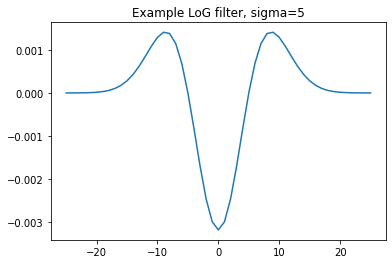

In [69]:
def log1d(sigma, num_points):
  """
  Returns num_points sampled the laplacian of a Gaussian with std=sigma
  """

  x_d = torch.zeros(num_points)
  laplacian_of_gaussian = torch.zeros(num_points)

  for i in range(num_points):
    x_ = -(num_points - 1)/2 + i 
    laplacian_of_gaussian[i] = (x_**2 - sigma**2)/(sigma**5 * math.sqrt(2*math.pi)) * math.exp(-0.5 * (x_/sigma) **2)

  assert(isinstance(laplacian_of_gaussian, torch.Tensor))
  assert(len(laplacian_of_gaussian.shape) == 1 and laplacian_of_gaussian.shape[0] == num_points)
  return laplacian_of_gaussian

sigma = 5
num_points = 51
laplacian_of_gaussian = log1d(sigma, num_points)

mag = (num_points + 1)/2
step = 2 * mag / (num_points + 1)
x = torch.arange(start=-mag, end=mag, step=step)[1:]

plt.figure()
plt.plot(x, laplacian_of_gaussian)
plt.title("Example LoG filter, sigma={}".format(sigma))
pass

# Approximating a LoG by a DoG

In [0]:
def dog1d(sigma, k, num_points):
  """
  DOG1D - return difference of gaussians of std k*sigma and sigma
  Syntax: g = dog1d(sigma, k, num_points)

  Output is symmetric with unit sampling period.
  Zero is sampled only when num_points is odd.

  Inputs:
    sigma: standard deviation
    k: standard deviation ratio
    num_points: output length.
  Outputs:
    dog: a torch tensor of difference of gaussians with dimension (num_points)
  """

  d_1 = gaussian1d(k*sigma, num_points)
  d_2 = gaussian1d(sigma, num_points)
  dog = (d_1 - d_2)/(sigma**2 * (k-1))

  assert(isinstance(dog, torch.Tensor))
  assert(len(dog.shape) == 1 and dog.shape[0] == num_points)
  return dog

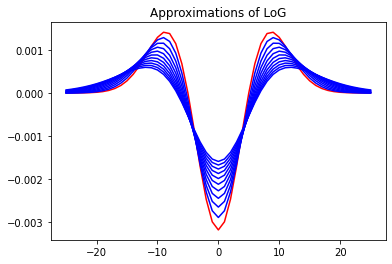

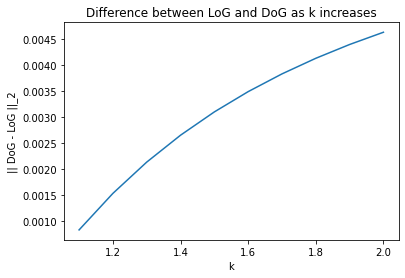

In [71]:
k_range = torch.arange(1.0, 2.1, 0.1)
diffs = []
approximations = []
for k in k_range:

  # Approximate the LoG with the DoG, computed with a standard deviation ratio
  # of k
  log_approx = dog1d(5, k, num_points)

  assert(isinstance(log_approx, torch.Tensor))
  assert(len(log_approx.shape) == 1 and log_approx.shape[0] == num_points)
  approximations.append(log_approx)
  diffs.append(torch.sqrt(torch.sum((laplacian_of_gaussian - log_approx)**2)))


plt.figure()
plt.plot(x, laplacian_of_gaussian, color='r')
for approx in approximations:
  plt.plot(x, approx, color='b')
plt.title('Approximations of LoG')

plt.figure()
plt.plot(k_range, diffs)
plt.xlabel('k')
plt.ylabel('|| DoG - LoG ||_2')
plt.title('Difference between LoG and DoG as k increases')
pass

# Detecting Sunflowers

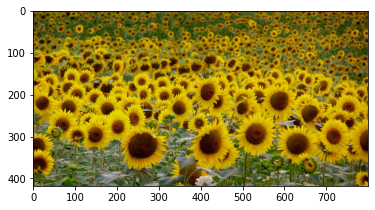

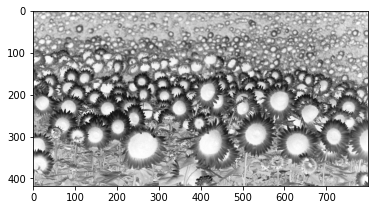

In [72]:
""" Loads and displays the sunflower image.  You must upload the image by 
clicking on the folder icon to the left, then clicking upload.  You will have to
re-upload the image every time your colab session restarts.
"""

# Inverts color channels because cv2 reads images as BGR while matplotlib
# uses RGB
original_im = cv2.imread('sunflowers.jpg')[:, :, ::-1]
original_im = cv2.resize(original_im, (0,0), fx=0.5, fy=0.5)
plt.imshow(original_im)

plt.figure()
# Discard everything except the green channel (where sunflowers seem to be
# salient)
im = original_im[:, :, 1]
plt.imshow(im, cmap='Greys')
# Puts the image onto the gpu
im = torch.tensor(im).to(torch.float32).cuda()
pass

In [0]:
def gaussian2d(sigma, num_points):
  """ Makes a discrete centered 2d gaussian
  Output is symmetric with unit sampling period.
  (0,0) is sampled only when num_points is odd.

  sigma - standard deviation
  num_points - number of points to sample in each dimension

  Output:
    g - a num_points x num_points tensor containing samples from the gaussian
  """
  """ YOUR CODE HERE """
  g = torch.zeros(num_points, num_points)

  for i in range(num_points):
    for j in range(num_points):
      x_ = -(num_points - 1)/2 + i 
      y_ = -(num_points - 1)/2 + j
      g[i,j] = 1/(sigma**2 * (2*math.pi)) * math.exp(-0.5 * ((x_**2 + y_ **2)/sigma **2))

  assert(isinstance(g, torch.Tensor))
  assert(g.shape == (num_points, num_points))
  return g

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


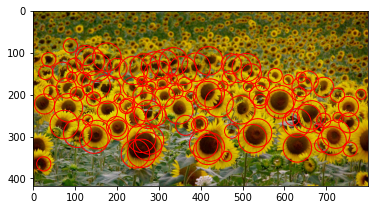

In [74]:
# Scale space parameters
n_scales = 7

sigma = 3
k = math.sqrt(2)

# Create blurred versions of the image with different scale filters
filtered_ims = torch.zeros(n_scales+1, im.shape[0], im.shape[1])
for i in range(0, n_scales + 1):
  sigma_i = sigma * k ** i
  fSize = 2 * int(5*sigma_i)+1

  # Question 3.3.b
  gaussian_filter = gaussian2d(sigma_i, fSize)
  gaussian_filter = gaussian_filter.view(1,1,fSize,fSize)
  kernel_g = torch.tensor(gaussian_filter).to(torch.float32).cuda()

  h = im.shape[0]
  w = im.shape[1]

  im_sunflower = im.view(1,1,h,w)

  filtered = torch.nn.functional.conv2d(input = im_sunflower, weight = kernel_g, padding=int(5 * sigma_i))
  filtered = filtered.view(h,w)

  # Blur the image with a 2D gaussian filter with standard deviation sigma_i
  # and a size of fSize x fSize.

  # This operation is pretty computationally expensive, so it should be run
  # on the gpu.
  # Solutions that do not perform their computation on the gpu will not be 
  # graded.


  filtered_ims[i] = filtered

# Difference of Gaussians
dog = filtered_ims[1:, :, :] - filtered_ims[:1, :, :]

# Performs non-maximal supression across x, y, and sigma
points = [[], [], [], []]
np_dog = dog.cpu().numpy().astype(np.float32)
max_across_scales = np.max(np_dog, axis=0)
#print (max_across_scales )
dilated_max_across_scales = cv2.dilate(max_across_scales, np.ones((3, 3), np.uint8))

for i, image in enumerate(np_dog):
  np_im = image
  np_im[dilated_max_across_scales != np_im] = 0.0
  
  xs, ys = np.where(np_im > 0.0)
  scores = np_im[xs, ys]
  points[0].extend(list(xs))
  points[1].extend(list(ys))
  points[2].extend(list(scores))
  points[3].extend([i] * len(scores))
points = torch.tensor(points)

# Discard maxima near the borders
threshold = 10
valid_indices = torch.where((points[0] > threshold) &
                            (points[1] > threshold) &
                            (points[0] < im.shape[0] - threshold) &
                            (points[1] < im.shape[1] - threshold))[0]
points = points[:, valid_indices]
points = points.reshape(points.shape[0], -1)


max_score = torch.max(dog)
max_ind = torch.where(points[2] > 0.5 * max_score)[0]
points = points[:,max_ind]
points = points.reshape(points.shape[0], -1)

# Keep only local maxima that have a response above
# 50% of the maximum response over the whole 3D scale
# space


fig, ax = plt.subplots(1)

ax.imshow(original_im)
#print (max_score)
for i in range(points.shape[1]):
  point = points[:, i]

  # Calculate the radius of the circle you will display
  radius = sigma * k ** point[3] * math.sqrt(2)

  circle = plt.Circle((point[1], point[0]), radius, color='r', fill=False)
  ax.add_patch(circle)


# Detecting 101 Dog

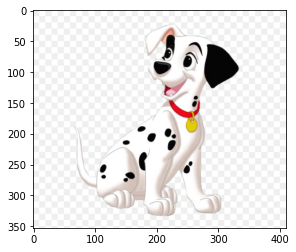

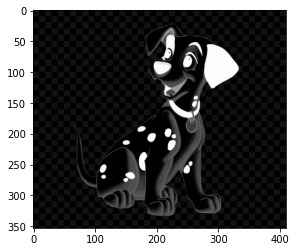

In [75]:
""" Loads and displays the sunflower image.  You must upload the image by 
clicking on the folder icon to the left, then clicking upload.  You will have to
re-upload the image every time your colab session restarts.
"""

# Inverts color channels because cv2 reads images as BGR while matplotlib
# uses RGB
original_im = cv2.imread('101_dog.jpg')[:, :, ::-1]
original_im = cv2.resize(original_im, (0,0), fx=0.5, fy=0.5)
plt.imshow(original_im)

plt.figure()
# Discard everything except the green channel (where sunflowers seem to be
# salient)
im = original_im[:, :, 1]
plt.imshow(im, cmap='Greys')
# Puts the image onto the gpu
im = torch.tensor(im).to(torch.float32).cuda()
pass

In [0]:
def gaussian2d(sigma, num_points):
  """ Makes a discrete centered 2d gaussian
  Output is symmetric with unit sampling period.
  (0,0) is sampled only when num_points is odd.

  sigma - standard deviation
  num_points - number of points to sample in each dimension

  Output:
    g - a num_points x num_points tensor containing samples from the gaussian
  """


  g = torch.zeros(num_points, num_points)

  for i in range(num_points):
    for j in range(num_points):
      x_ = -(num_points - 1)/2 + i 
      y_ = -(num_points - 1)/2 + j
      g[i,j] = 1/(sigma**2 * (2*math.pi)) * math.exp(-0.5 * ((x_**2 + y_ **2)/sigma **2))


  assert(isinstance(g, torch.Tensor))
  assert(g.shape == (num_points, num_points))
  return g

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


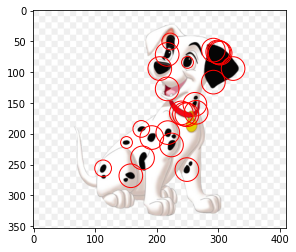

In [86]:
# Scale space parameters
n_scales = 7

sigma = 3
k = math.sqrt(2)

# Create blurred versions of the image with different scale filters
filtered_ims = torch.zeros(n_scales+1, im.shape[0], im.shape[1])
for i in range(0, n_scales + 1):
  sigma_i = sigma * k ** i
  fSize = 2 * int(5*sigma_i)+1

  # Question 3.3.b
  gaussian_filter = gaussian2d(sigma_i, fSize)
  gaussian_filter = gaussian_filter.view(1,1,fSize,fSize)
  kernel_g = torch.tensor(gaussian_filter).to(torch.float32).cuda()

  h = im.shape[0]
  w = im.shape[1]

  im_sunflower = im.view(1,1,h,w)

  filtered = torch.nn.functional.conv2d(input = im_sunflower, weight = kernel_g, padding=int(5 * sigma_i))
  filtered = filtered.view(h,w)

  # Blur the image with a 2D gaussian filter with standard deviation sigma_i
  # and a size of fSize x fSize.

  # This operation is pretty computationally expensive, so it should be run
  # on the gpu.
  # Solutions that do not perform their computation on the gpu will not be 
  # graded.


  filtered_ims[i] = filtered

# Difference of Gaussians
dog = filtered_ims[1:, :, :] - filtered_ims[:1, :, :]

# Performs non-maximal supression across x, y, and sigma
points = [[], [], [], []]
np_dog = dog.cpu().numpy().astype(np.float32)
max_across_scales = np.max(np_dog, axis=0)
#print (max_across_scales )
dilated_max_across_scales = cv2.dilate(max_across_scales, np.ones((3, 3), np.uint8))

for i, image in enumerate(np_dog):
  np_im = image
  np_im[dilated_max_across_scales != np_im] = 0.0
  
  xs, ys = np.where(np_im > 0.0)
  scores = np_im[xs, ys]
  points[0].extend(list(xs))
  points[1].extend(list(ys))
  points[2].extend(list(scores))
  points[3].extend([i] * len(scores))
points = torch.tensor(points)

# Discard maxima near the borders
threshold = 10
valid_indices = torch.where((points[0] > threshold) &
                            (points[1] > threshold) &
                            (points[0] < im.shape[0] - threshold) &
                            (points[1] < im.shape[1] - threshold))[0]
points = points[:, valid_indices]
points = points.reshape(points.shape[0], -1)


# Question 3.3.c

max_score = torch.max(dog)
max_ind = torch.where(points[2] > 0.5 * max_score)[0]
points = points[:,max_ind]
points = points.reshape(points.shape[0], -1)

# Keep only local maxima that have a response above
# 50% of the maximum response over the whole 3D scale
# space


fig, ax = plt.subplots(1)

ax.imshow(original_im)
#print (max_score)
for i in range(points.shape[1]):
  point = points[:, i]

  # Calculate the radius of the circle you will display
  radius = sigma * k ** point[3] * 0.8

  circle = plt.Circle((point[1], point[0]), radius, color='r', fill=False)
  ax.add_patch(circle)